# Pycaret

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error

from pycaret.regression import *

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import argparse
# import wandb
# wandb.init(project="DACON_235942", name="pycaret")

parser = argparse.ArgumentParser(description="pycaret")
parser.add_argument('--ensemble', default="blending", type=str) # blending or stacking
parser.add_argument('--top_n_model', default=5, type=int)
parser.add_argument('--tune_iter', default=10, type=int)
parser.add_argument('--scaler', default="standard", type=str) # standard or minmax
parser.add_argument('--cv', default=10, type=int)
parser.add_argument('--seed', default=1011, type=int)
args = parser.parse_args('')

# wandb.config.update(args)

ensemble = args.ensemble
top_n_model = args.top_n_model
tune_iter = args.tune_iter
scaler = args.scaler
cv = args.cv
seed = args.seed

if scaler == "standard":
    scaler="zscore"
elif scaler == "minmax":
    scaler="minmax"

def set_seeds(seed=seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

set_seeds()

train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

train.head()

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
0,1,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,8.106,False,1643690.90
1,2,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,8.106,True,1641957.44
2,3,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,8.106,False,1611968.17
3,4,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,8.106,False,1409727.59
4,5,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,8.106,False,1554806.68


## Preprocessing

In [2]:
train["Weekly_Sales"] = np.log(train["Weekly_Sales"])

train["Store"] = train["Store"].astype("object")
test["Store"] = test["Store"].astype("object")

train["Date"] = pd.to_datetime(train["Date"])
test["Date"] = pd.to_datetime(test["Date"])
    
train['year'] = train["Date"].dt.year
train['month'] = train["Date"].dt.month
train["day"] = train["Date"].dt.day

test['year'] = test["Date"].dt.year
test['month'] = test["Date"].dt.month
test["day"] = test["Date"].dt.day

train["week"] = train["Date"].dt.week
test["week"] = test["Date"].dt.week

def seasonal(x):
    if (x >= 3) & (x <= 5):
        x = 1
    elif (x >= 6) & (x <= 8):
        x = 2
    elif (x >= 9) & (x <= 11):
        x = 3
    elif (x >= 12) | (x <= 2):
        x = 4
    return x

train["season"] = train["month"].apply(lambda x : seasonal(x))
test["season"] = test["month"].apply(lambda x : seasonal(x))

train["IsHoliday"] = train["IsHoliday"].apply(lambda x : 1 if x==True else 0)
test["IsHoliday"] = test["IsHoliday"].apply(lambda x : 1 if x==True else 0)

train = train.sort_values(["Date", "Store"]).reset_index(drop=True)

train.head()

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales,year,month,day,week,season
0,35,1,2010-01-10,71.89,2.603,NaN,NaN,NaN,NaN,NaN,7.838,0,14.189368,2010,1,10,1,4
1,174,2,2010-01-10,69.24,2.603,NaN,NaN,NaN,NaN,NaN,8.163,0,14.418427,2010,1,10,1,4
2,313,3,2010-01-10,73.60,2.603,NaN,NaN,NaN,NaN,NaN,7.564,0,12.790476,2010,1,10,1,4
3,452,4,2010-01-10,63.96,2.619,NaN,NaN,NaN,NaN,NaN,7.127,0,14.426808,2010,1,10,1,4
4,591,5,2010-01-10,71.10,2.603,NaN,NaN,NaN,NaN,NaN,6.768,0,12.553831,2010,1,10,1,4


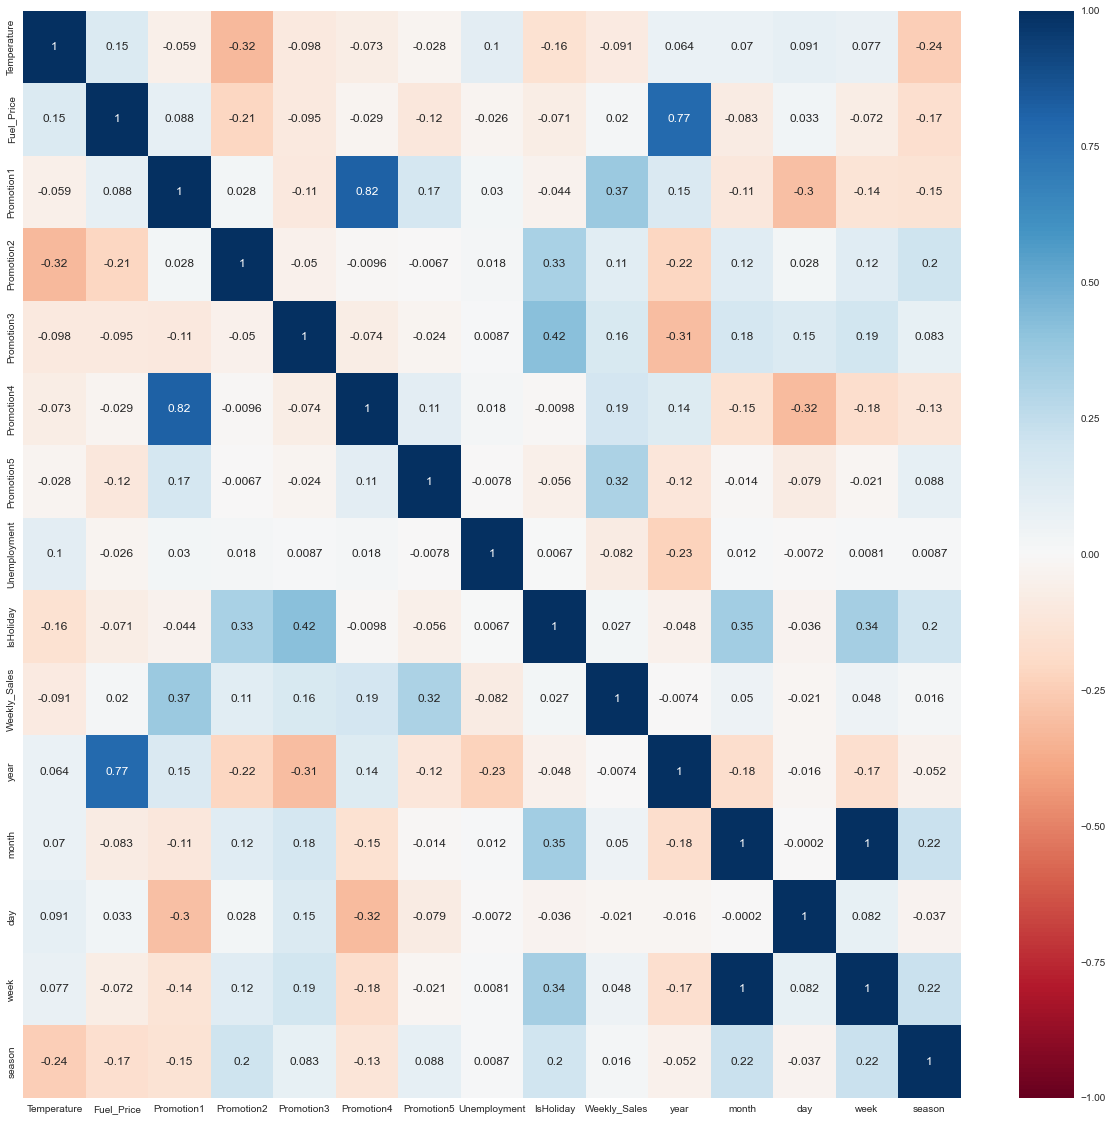

In [3]:
train = train.drop(["id", "Date"], axis=1)
test = test.drop(["id", "Date"], axis=1)

plt.figure(figsize=(21,20))
sns.heatmap(train.corr(), vmin=-1, vmax=1, cmap='RdBu', annot=True)
plt.show()

In [4]:
dataset = pd.concat([train, test], axis=0).reset_index(drop=True)

df = pd.DataFrame()
for i in tqdm(dataset["Store"].unique()):

    dataset2 = dataset[dataset["Store"]==i]

    for j in dataset2["week"].unique():
        
        temp = dataset2[dataset2["week"]==j]
        
        if (temp.isnull().sum() / len(temp)).max() != 1:

            imputer = SimpleImputer()
            temp[temp.columns]=imputer.fit_transform(temp)
        
        df = pd.concat([df, temp], axis=0)

df.isnull().sum()

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:14<00:00,  3.01it/s]


Store              0
Temperature        0
Fuel_Price         0
Promotion1      1883
Promotion2      2401
Promotion3      2117
Promotion4      2198
Promotion5      1868
Unemployment       0
IsHoliday          0
Weekly_Sales     124
year               0
month              0
day                0
week               0
season             0
dtype: int64

In [5]:
train = df.loc[train.index]
test = df.drop(train.index, axis=0).reset_index(drop=True)
test = test.drop(["Weekly_Sales"], axis=1)

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6255 entries, 0 to 6254
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6255 non-null   object 
 1   Temperature   6255 non-null   float64
 2   Fuel_Price    6255 non-null   float64
 3   Promotion1    4374 non-null   float64
 4   Promotion2    3960 non-null   float64
 5   Promotion3    4157 non-null   float64
 6   Promotion4    4091 non-null   float64
 7   Promotion5    4387 non-null   float64
 8   Unemployment  6255 non-null   float64
 9   IsHoliday     6255 non-null   float64
 10  Weekly_Sales  6255 non-null   float64
 11  year          6255 non-null   float64
 12  month         6255 non-null   float64
 13  day           6255 non-null   float64
 14  week          6255 non-null   float64
 15  season        6255 non-null   float64
dtypes: float64(15), object(1)
memory usage: 782.0+ KB


## Training

In [6]:
s = setup(train, target='Weekly_Sales',
          imputation_type="iterative", iterative_imputation_iters=5,
          categorical_features=["Store"],
          numeric_features=["year", "month", "day", "week", "season"],
          numeric_imputation='median',
          normalize=True, normalize_method=scaler,
          fold_strategy='timeseries', fold=cv,
          use_gpu=True, session_id=seed, log_experiment=True)

,Description,Value
0,session_id,1011
1,Target,Weekly_Sales
2,Original Data,"(6255, 16)"
3,Missing Values,True
4,Numeric Features,13
5,Categorical Features,2
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(4378, 58)"


2022/07/17 21:56:27 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



In [7]:
def RMSE_exp(true, pred):
    rmse_exp = mean_squared_error(np.exp(true).round(2),
                                  np.exp(pred).round(2),
                                  squared=True)
    return rmse_exp

add_metric('RMSE_exp', 'RMSE_exp', RMSE_exp, greater_is_better=False)

Name                                                       RMSE_exp
Display Name                                               RMSE_exp
Score Function            <function RMSE_exp at 0x000001E9075C2430>
Scorer               make_scorer(RMSE_exp, greater_is_better=False)
Target                                                         pred
Args                                                             {}
Greater is Better                                             False
Custom                                                         True
Name: RMSE_exp, dtype: object

In [8]:
%%time

if ensemble == 'blending':
    blender = blend_models(compare_models(sort='RMSE_exp', n_select=top_n_model), choose_better=True)
    tuned_blender = tune_model(blender, n_iter=tune_iter, optimize='RMSE_exp', search_library='optuna', choose_better=True)
    final_model = finalize_model(tuned_blender)

if ensemble == 'stacking':
    stacker = stack_models(compare_models(sort='RMSE_exp', n_select=top_n_model), choose_better=True)
    tuned_stacker = tune_model(stacker, n_iter=tune_iter, optimize='RMSE_exp', search_library='optuna', choose_better=True)
    final_model = finalize_model(tuned_stacker)

final_model

,MAE,MSE,RMSE,R2,RMSLE,MAPE,RMSE_exp
Fold,,,,,,,
0,0.0965,0.0178,0.1334,0.9448,0.0090,0.0070,26480127226.0937
1,0.0680,0.0085,0.0920,0.9753,0.0063,0.0050,12220230206.7725
2,0.0654,0.0085,0.0920,0.9756,0.0062,0.0048,14053015964.7538
3,0.0647,0.0082,0.0906,0.9774,0.0061,0.0047,14234873921.4468
4,0.0570,0.0062,0.0790,0.9819,0.0054,0.0042,8763276235.0732
5,0.0539,0.0055,0.0742,0.9827,0.0050,0.0039,8923667756.5988
6,0.0550,0.0056,0.0750,0.9839,0.0051,0.0040,7542408900.0078
7,0.0581,0.0070,0.0836,0.9793,0.0057,0.0043,11756146634.9576
8,0.0558,0.0061,0.0779,0.9832,0.0053,0.0041,9659016170.7467


CPU times: total: 2h 10min 42s
Wall time: 8min 43s


VotingRegressor(estimators=[('et',
                             ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                                 criterion='mse',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100, n_jobs=-1,
                                                 oob_score=False,
                                  

In [9]:
print("rmse_best: ", pull()["RMSE_exp"].loc["Mean"])

# wandb.log({'RMSE_best': pull()["RMSE_exp"].loc["Mean"]})

rmse_best:  13497973393.1984


In [10]:
evaluate_model(final_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

## Inference

In [11]:
predictions = predict_model(final_model, data=test)
prediction = predictions['Label']

In [12]:
submission = pd.read_csv("data/sample_submission.csv")
submission["Weekly_Sales"] = np.exp(prediction).round(2)
submission.to_csv("submission.csv", index=False)

## Cheet

In [13]:
cheet = pd.read_csv("kaggle/sales data-set.csv")
cheet["Date"] = pd.to_datetime(cheet["Date"])
cheet = cheet.sort_values(["Date", "Store"]).reset_index(drop=True)
cheet = cheet.groupby(by=["Store", "Date"]).sum().reset_index()
cheet = cheet.drop(["Dept", "IsHoliday"], axis=1)

temp = pd.read_csv("data/test.csv")
temp["Date"] = pd.to_datetime(temp["Date"])
cheet = pd.merge(temp, cheet)["Weekly_Sales"]

rmse_cheet = mean_squared_error(submission["Weekly_Sales"], cheet, squared=True)
print(f"rmse_cheet: {rmse_cheet}")

# wandb.log({'RMSE_cheet': rmse_cheet})

rmse_cheet: 9628687212.853813
